# n-qubit QFT
Here we automate the construction of QFT n-qubit circuits
We use parts of this notebook https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html#generalqft

In [1]:
import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector

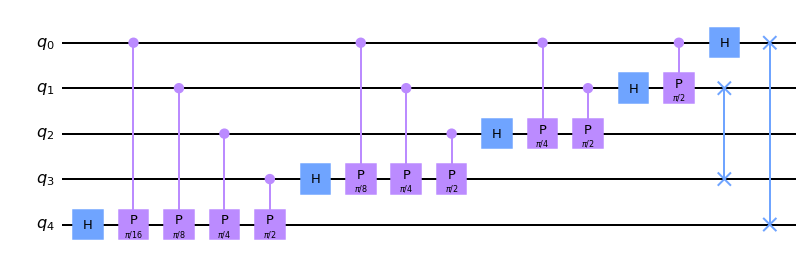

In [51]:
def qft_rotations(circuit, n):
    if n == 0: # Exit function if circuit is empty
        return circuit
    n -= 1 # Indexes start from 0
    circuit.h(n) # Apply the H-gate to the most significant qubit
    for qubit in range(n):
        # For each less significant qubit, we need to do a
        # smaller-angled controlled rotation: 
        circuit.cp(pi/2**(n-qubit), qubit, n)
        
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)
    
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

# Let's see how it looks:
nqubits = 5
qc = QuantumCircuit(nqubits)
qft(qc,nqubits)
qc.draw('mpl')

In [52]:
def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

In [53]:
# convert QFT to a custom gate
nqubits = 5
qc_tmp = QuantumCircuit(nqubits)
qft(qc_tmp,nqubits)

# we can convert the previous circuit to a custom gate
QFT_gate = qc_tmp.to_gate()
QFT_gate.label = "QFT"

# make gate from inverse circuit
QFT_inverse = qc_tmp.inverse()#.decompose()
QFT_inverse_gate = QFT_inverse.to_gate()
QFT_inverse_gate.label = "QFT${}^{-1}$"

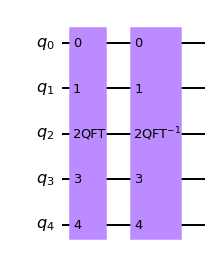

In [54]:
# we can then add the new gate to a circuit many times
qc = QuantumCircuit(nqubits)
qc.append(QFT_gate,np.arange(0,nqubits).tolist())
qc.append(QFT_inverse_gate,np.arange(0,nqubits).tolist())
qc.draw('mpl') # .decompose()

In [55]:
# We now extract the overall unitary matrix from the circuit, which should be very close to the identity

# Select the UnitarySimulator from the Aer provider
simulator = Aer.get_backend('unitary_simulator')
# Execute and get counts
result = execute(qc, simulator).result()
unitary = result.get_unitary(qc)
print("Circuit unitary:\n", np.real(unitary) )

Circuit unitary:
 [[ 1.00000000e+00 -3.07708769e-17 -3.68979431e-17 ...  1.25378061e-17
   3.10051402e-17  3.49046165e-17]
 [ 5.17149002e-17  1.00000000e+00 -4.00003722e-17 ...  1.33277877e-17
   1.32582352e-17  5.10877058e-17]
 [ 8.68731000e-18  4.78135859e-17  1.00000000e+00 ...  2.34016307e-18
   4.39774541e-17  8.10967635e-18]
 ...
 [-8.90697586e-18 -5.37873416e-17 -7.35578208e-18 ...  1.00000000e+00
  -4.48481612e-17 -3.42465270e-17]
 [-6.82716302e-17 -1.61609399e-17 -5.31625751e-17 ...  4.31683607e-17
   1.00000000e+00 -3.69603536e-17]
 [-2.59978975e-17 -2.34471750e-17 -8.52415154e-18 ...  3.91882229e-17
   4.60761579e-17  1.00000000e+00]]
